In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers
import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from transformers import XLMRobertaTokenizer

In [3]:
!scp sagarsj42@ada:/share1/sagarsj42/semeval-2022-task-8-train-df.csv .
!scp sagarsj42@ada:/share1/sagarsj42/semeval-2022-task-8-eval-df.csv .

semeval-2022-task-8-train-df.csv              100%   27MB  27.3MB/s   00:00    
semeval-2022-task-8-eval-df.csv               100%   27MB  27.4MB/s   00:00    


In [4]:
train_df = pd.read_csv('semeval-2022-task-8-train-df.csv', index_col=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4964 entries, 0 to 4963
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pair_id             4964 non-null   object 
 1   score               4964 non-null   float64
 2   id_1                4964 non-null   int64  
 3   title_1             4918 non-null   object 
 4   text_1              4931 non-null   object 
 5   keywords_1          4964 non-null   object 
 6   meta_keywords_1     4964 non-null   object 
 7   tags_1              4964 non-null   object 
 8   summary_1           12 non-null     object 
 9   meta_description_1  4136 non-null   object 
 10  meta_lang_1         4304 non-null   object 
 11  id_2                4964 non-null   int64  
 12  title_2             4925 non-null   object 
 13  text_2              4919 non-null   object 
 14  keywords_2          4964 non-null   object 
 15  meta_keywords_2     4964 non-null   object 
 16  tags_2

In [5]:
train_df.head()

,pair_id,score,id_1,title_1,text_1,keywords_1,meta_keywords_1,tags_1,summary_1,meta_description_1,meta_lang_1,id_2,title_2,text_2,keywords_2,meta_keywords_2,tags_2,summary_2,meta_description_2,meta_lang_2
0,1484084337_1484110209,4.000000,1484084337,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",[],"['Highway Fatal-DUI-West Virginia', 'Martinsbu...",[],NaN,Police in West Virginia say a suspected drunke...,en,1484110209,Haiti’s leader marks independence day amid sec...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",[],"['CB-Haiti-Political Turmoil', 'Jean', 'Haiti'...",[],NaN,Haitian President Jovenel Moïse has broken wit...,en
1,1484396422_1483924666,3.666667,1484396422,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,[],[''],[],NaN,-,en,1483924666,Fire kills more than 30 animals at zoo in west...,BERLIN - A fire at a zoo in western Germany in...,[],"['smg2_world', 'smg_europe', 'smg2_news']",[],NaN,BERLIN - A fire at a zoo in western Germany in...,en
2,1484698254_1483758694,2.333333,1484698254,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,[],[''],[],NaN,NaN,en,1483758694,"Trump says he does not expect war with Iran, ‘...","PALM BEACH, United States — US President Donal...",[],[''],"['See All', 'Full Coverage 2019-2020 Israeli e...",NaN,US president says response to rioting by pro-I...,en
3,1576314516_1576455088,2.000000,1576314516,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,[],['zomato uber eats business acquisition india ...,"['Zomato', 'Uber Eats']",NaN,Zomato on Tuesday announced it has acquired Ub...,en,1576455088,Indian Online Food Delivery Market to Hit $8 B...,Rapid digitisation and growth in both online b...,[],['indian online food delivery market to hit us...,"['ber', 'Zomato', 'Swiggy', 'Uber Eats']",NaN,The report by Google and Boston Consulting Gro...,en
4,1484036253_1483894099,1.250000,1484036253,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,[],[''],[],NaN,India has approved its third lunar mission mon...,en,1483894099,India targets new moon mission in 2020,BANGALORE: India plans to make a fresh attempt...,[],"['India', 'space']","['India', 'space']",NaN,India plans to make a fresh attempt to land an...,en


In [6]:
def get_id_texts(df):
    id1 = df['id_1'].tolist()
    id2 = df['id_2'].tolist()
    text1 = df['text_1'].tolist()
    text2 = df['text_2'].tolist()
    id_text = dict()

    for idx, text in zip(id1, text1):
        id_text[idx] = text
    for idx, text in zip(id2, text2):
        id_text[idx] = text

    return id_text

In [7]:
id_text = get_id_texts(train_df)
len(id_text)

9476

In [8]:
list(id_text.keys())[:10]

[1484084337,
 1484396422,
 1484698254,
 1576314516,
 1484036253,
 1484189120,
 1484034982,
 1484188439,
 1484011751,
 1484035244]

In [9]:
text = id_text[1484189120]
text

'The Simon Wiesenthal Center called on the White House to direct the FBI to form a task force to focus exclusively on anti-Semitism following the stabbings in Monsey, N.Y.\n\nWiesenthal Center founder and Dean Rabbi Marvin Hier and Associate Dean and Director of Global Social Action Agenda said in a Dec. 28 statement, “Enough is enough! Jews should not have to fear for their lives in America to go to their houses of worship. The FBI must step up and take the lead in all recent violent hate crimes targeting religious Jews.”\n\nHier told the Journal in a phone interview that the Dec. 28 Monsey stabbings that resulted in five injured reminded him of Nazi Germany in the 1930s. “Jews were beaten up on the corner. Windows were broken … that’s how it started,” Hier said. “And the population centers tolerated it. Nobody spoke out against it; we didn’t have a plan against it.”\n\nHe argued that the rise of anti-Semitism in the United States has become such an epidemic that more action is needed

In [10]:
len(text)

3555

In [11]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
tokenizer

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [12]:
text_tok = tokenizer.tokenize(text)
len(text_tok), text_tok

(879,
 ['▁The',
  '▁Simon',
  '▁Wie',
  'sen',
  'thal',
  '▁Center',
  '▁called',
  '▁on',
  '▁the',
  '▁White',
  '▁House',
  '▁to',
  '▁direct',
  '▁the',
  '▁FBI',
  '▁to',
  '▁form',
  '▁a',
  '▁task',
  '▁force',
  '▁to',
  '▁focus',
  '▁exclusive',
  'ly',
  '▁on',
  '▁anti',
  '-',
  'Se',
  'mit',
  'ism',
  '▁following',
  '▁the',
  '▁stab',
  'bing',
  's',
  '▁in',
  '▁Mon',
  'sey',
  ',',
  '▁N',
  '.',
  'Y',
  '.',
  '▁Wie',
  'sen',
  'thal',
  '▁Center',
  '▁found',
  'er',
  '▁and',
  '▁De',
  'an',
  '▁Rabbi',
  '▁Mar',
  'vin',
  '▁Hier',
  '▁and',
  '▁',
  'Associate',
  '▁De',
  'an',
  '▁and',
  '▁Director',
  '▁of',
  '▁Global',
  '▁Social',
  '▁Action',
  '▁Agenda',
  '▁said',
  '▁in',
  '▁a',
  '▁Dec',
  '.',
  '▁28',
  '▁statement',
  ',',
  '▁“',
  'En',
  'ough',
  '▁is',
  '▁enough',
  '!',
  '▁Je',
  'ws',
  '▁should',
  '▁not',
  '▁have',
  '▁to',
  '▁fear',
  '▁for',
  '▁their',
  '▁lives',
  '▁in',
  '▁America',
  '▁to',
  '▁go',
  '▁to',
  '▁their',


In [13]:
text_tok_enc = tokenizer.encode(text)
len(text_tok_enc), text_tok_enc

Token indices sequence length is longer than the specified maximum sequence length for this model (881 > 512). Running this sequence through the model will result in indexing errors


(881,
 [0,
  581,
  26328,
  4887,
  1015,
  56680,
  11588,
  35839,
  98,
  70,
  22392,
  13038,
  47,
  8951,
  70,
  83085,
  47,
  3173,
  10,
  66211,
  37772,
  47,
  32153,
  97629,
  538,
  98,
  2874,
  9,
  4233,
  4007,
  8780,
  25632,
  70,
  66604,
  23709,
  7,
  23,
  7465,
  31947,
  4,
  541,
  5,
  1723,
  5,
  4887,
  1015,
  56680,
  11588,
  14037,
  56,
  136,
  262,
  66,
  71916,
  1784,
  2082,
  5389,
  136,
  6,
  228214,
  262,
  66,
  136,
  31068,
  111,
  13453,
  7142,
  57945,
  89660,
  2804,
  23,
  10,
  25755,
  5,
  1372,
  63805,
  4,
  52,
  7768,
  72089,
  83,
  20174,
  38,
  845,
  19725,
  5608,
  959,
  765,
  47,
  30783,
  100,
  2363,
  60742,
  23,
  21629,
  47,
  738,
  47,
  2363,
  18276,
  7,
  111,
  225415,
  5,
  581,
  83085,
  8110,
  29954,
  1257,
  136,
  5646,
  70,
  37105,
  23,
  756,
  17309,
  48673,
  35463,
  138379,
  30388,
  214,
  167821,
  845,
  19725,
  974,
  5389,
  30745,
  70,
  34419,
  23,
  10,
  24

In [14]:
text_char_len = list()
text_tok_len = list()

for text in id_text.values():
    text = str(text)
    text_char_len.append(len(text))
    text_tok_len.append(len(tokenizer.encode(text)))

text_char_len = np.array(text_char_len)
text_tok_len = np.array(text_tok_len)

len(text_char_len), len(text_tok_len)

(9476, 9476)

In [15]:
text_char_len.min(), text_char_len.max(), np.median(text_char_len), text_char_len.mean(), text_char_len.std()

(3, 100000, 1709.0, 2423.9204305614185, 2957.532525663086)

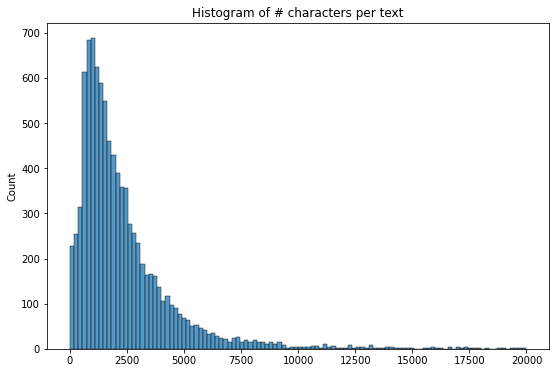

In [16]:
plt.figure(figsize=(9, 6))
sns.histplot(text_char_len, binrange=(0, 20000))
plt.title('Histogram of # characters per text')
plt.show()

In [17]:
text_tok_len.min(), text_tok_len.max(), np.median(text_tok_len), text_tok_len.mean(), text_tok_len.std()

(3, 61057, 413.0, 588.4776276910088, 953.7733913044722)

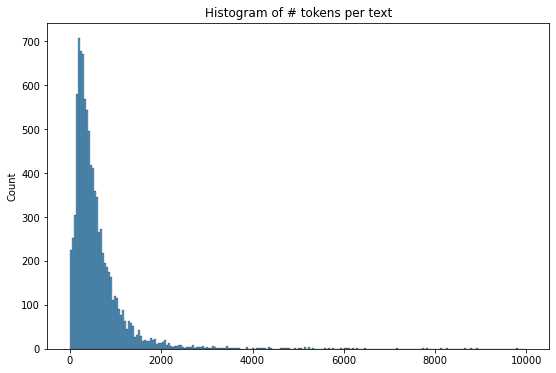

In [18]:
plt.figure(figsize=(9, 6))
sns.histplot(text_tok_len, binrange=(0, 10000))
plt.title('Histogram of # tokens per text')
plt.show()

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
sss

StratifiedShuffleSplit(n_splits=1, random_state=None, test_size=0.1,
            train_size=None)

In [20]:
y_sss = list(map(round, train_df['score']))
len(y_sss)

4964

In [21]:
for train_index, dev_index in sss.split(train_df, y_sss):
    trains_df = train_df.iloc[train_index]
    dev_df = train_df.iloc[dev_index]

trains_df.shape, dev_df.shape

((4467, 20), (497, 20))

In [22]:
trains_df.to_csv('semeval8-train-sss.csv')
dev_df.to_csv('semeval8-dev.csv')